In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import torch
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


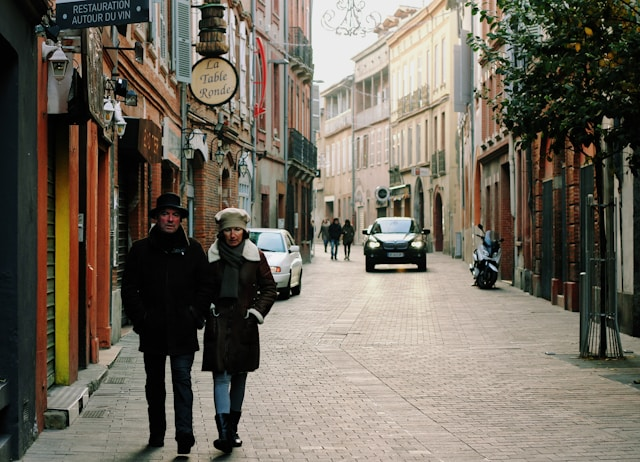

In [4]:
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
import torchvision.transforms as T

raw_image = Image.open("img.jpg")
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# preprocess and batch the image
input_tensor = transform(raw_image).unsqueeze(0).to(device)
raw_image

In [5]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True).to(device)
model.eval()

Using cache found in /home/frederic.boisnard/.cache/torch/hub/facebookresearch_detr_main
/home/frederic.boisnard/virtualenvs/detr2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frederic.boisnard/virtualenvs/detr2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [6]:
input_tensor.device

device(type='cuda', index=0)

In [7]:
outputs = model(input_tensor)

In [8]:
outputs.keys()

dict_keys(['pred_logits', 'pred_boxes'])

### Checks gradients

In [9]:
x = input_tensor.detach().clone().requires_grad_(True)

In [10]:
try:
    model(x)
except Exception as e:
    print(e)

A view was created in no_grad mode and is being modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.


In [11]:
from xplique.concepts.latent_data_detr import LatentDataDetr, buildTorchDetrLatentExtractor

2025-09-05 17:07:39.089727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757084859.101587 3331215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757084859.105150 3331215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 17:07:39.117391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# from xplique.utils_functions.object_detection_torch import check_model_gradients
from xplique.utils_functions.object_detection.torch.gradients_check import check_model_gradients

In [16]:
check = check_model_gradients(model, input_tensor)

🟠 Erreur: A view was created in no_grad mode and is being modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.


In [17]:
# A view was created in no_grad mode and is being modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [18]:
from xplique.concepts.latent_data_detr import LatentDataDetr, buildTorchDetrLatentExtractor

In [19]:
latent_extractor = buildTorchDetrLatentExtractor(model)

In [20]:
# pass model.h(model(x)) instead of model(x) to avoid the error
check = check_model_gradients(lambda x: model.h(model(x)), input_tensor)

🟠 Erreur: A view was created in no_grad mode and is being modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.


In [21]:
check = check_model_gradients(latent_extractor, input_tensor)

✅ Gradients OK - somme=18213.996094


In [24]:
# from xplique.utils_functions.box_manager import filter_boxes, BoxFormat
# from display_image_with_boxes import display_image_with_boxes

from xplique.utils_functions.object_detection.common.box_manager import BoxFormat
from xplique.utils_functions.object_detection.torch.box_manager import filter_boxes
from xplique.plots.display_image_with_boxes import display_image_with_boxes

In [25]:
classes_names = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
label_to_color = {'person': 'r',
            'bicycle': 'b',
            'car': 'g',
            'motorcycle': 'y',
            'truck': 'orange'}

In [26]:
results = latent_extractor(input_tensor)

In [27]:
results.shape

torch.Size([1, 100, 96])

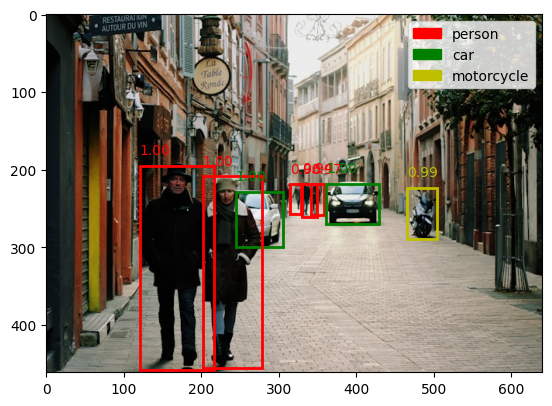

In [28]:
fig = display_image_with_boxes(raw_image, results[0], BoxFormat.XYXY, True, classes_names, label_to_color, accuracy=0.85)

In [29]:
import xplique
from xplique.attributions import Saliency
from xplique.plots import plot_attributions, plot_attribution

In [30]:
from torchvision.transforms.functional import to_tensor
image = to_tensor(raw_image)
# transpose coords for tensorflow compatibility
image = image.numpy().transpose(1, 2, 0)
print(image.shape)

(462, 640, 3)


In [31]:
input_tensor.shape

torch.Size([1, 3, 800, 800])

In [32]:
targets = latent_extractor(input_tensor)
print(targets.shape)

filtered_targets = filter_boxes(targets, accuracy=0.9, class_id=classes_names.index('car'))
# convert this list of torch tensors to a single np.array
box_to_explain = np.array([target.detach().cpu().numpy() for target in filtered_targets])
print(box_to_explain.shape)

torch.Size([1, 100, 96])
(1, 2, 96)


In [33]:
# operator=xplique.Tasks.OBJECT_DETECTION

# explainer = Saliency(latent_extractor, operator=operator, batch_size=None)
# explanation = explainer.explain(input_tensor.detach().cpu().numpy(), targets=box_to_explain)

# plot_attributions(explanation, [np.array(raw_image)], img_size=6.,
#                 cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

In [34]:
from xplique.wrappers import TorchWrapper

In [35]:
# latent_extractor = latent_extractor.eval()
# torch_wrapped_model = TorchWrapper(latent_extractor, device=device, is_channel_first=False)
# torch_wrapped_model(input_tensor.detach().cpu().numpy()).shape
# input_tensor.shape

In [36]:
torch_wrapped_model = TorchWrapper(latent_extractor, device=device, is_channel_first=True)
# true: the torch model expects a channel as 1st dim -> the torch wrappwer will transpose the input for the torch model
# false: input is not changed
# true: TF input format -> wrapper -> torch format -> torch model

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [37]:
input_tensor_tf_dim = input_tensor.detach().cpu().numpy().transpose(0, 2, 3, 1)
print(input_tensor_tf_dim.shape)
torch_wrapped_model(input_tensor_tf_dim).shape

(1, 800, 800, 3)


I0000 00:00:1757085164.081991 3331215 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6365 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_inputs = self.torch.Tensor(np_inputs)


TensorShape([1, 100, 96])

In [38]:
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [39]:
targets = torch_wrapped_model(input_tensor_tf_dim)
print(targets.shape)

(1, 100, 96)


In [40]:
explanation = explainer.explain(input_tensor_tf_dim, targets=box_to_explain)
print(explanation.shape)

Saliency.expain()
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 800, 800, 3)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 800, 800, 1)


2025-09-05 17:12:45.686744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# import tensorflow as tf
# gradients = explainer.batch_gradient(explainer.model, inputs=input_tensor.cpu().numpy(), targets=box_to_explain, batch_size=1)
# gradients = tf.abs(gradients)
# print(gradients.shape)

In [42]:
# plot_attributions(gradients, [np.array(image)], img_size=6.,
#                 cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

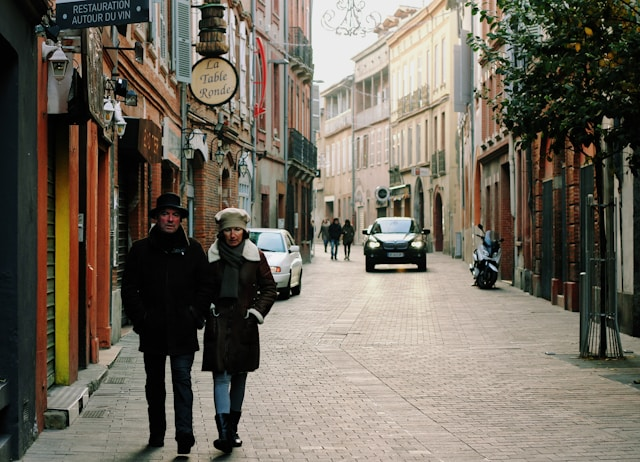

In [43]:
raw_image

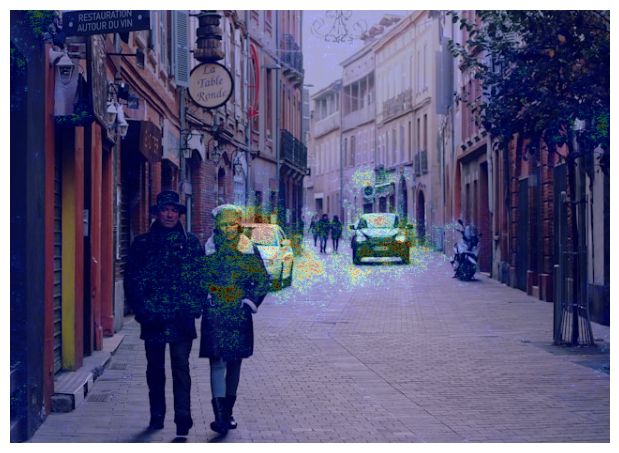

In [44]:
plot_attributions(explanation, [np.array(raw_image)], img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

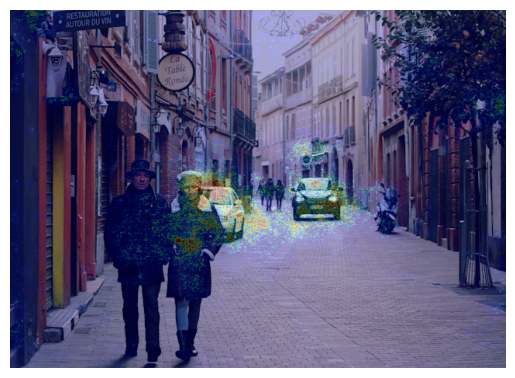

In [45]:
plot_attribution(explanation[0], image=raw_image, cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

In [47]:
from xplique.concepts import HolisticCraftObjectDetectionTorch as Craft
from xplique.plots.display_image_with_boxes import display_image_with_boxes

In [48]:
input_tensor.shape

torch.Size([1, 3, 800, 800])

In [49]:
latent_extractor(input_tensor).shape

torch.Size([1, 100, 96])

In [50]:
latent_extractor.input_to_latent(input_tensor).pdim()

Features: list of NestedTensor of len: 1
	Features[0].tensors shape: torch.Size([1, 2048, 25, 25])
	Features[0].mask shape: torch.Size([1, 25, 25])
Pos len: 1
	Pos[0] shape: torch.Size([1, 256, 25, 25])


In [51]:
latent_extractor.input_to_latent_batched(input_tensor).pdim()

Total batches: 1, Batch size: 1, Dataset size: 1
Features: list of NestedTensor of len: 1
	Features[0].tensors shape: torch.Size([1, 2048, 25, 25])
	Features[0].mask shape: torch.Size([1, 25, 25])
Pos len: 1
	Pos[0] shape: torch.Size([1, 256, 25, 25])


In [52]:
craft = Craft(latent_extractor = latent_extractor,
        number_of_concepts = 10)
_ = craft.fit(input_tensor)

Total batches: 1, Batch size: 1, Dataset size: 1
activations shape before NMF: torch.Size([1, 25, 25, 2048])
coeffs_u shape after NMF.fit_transform(): (625, 10)
coeffs_u rearranged shape: (1, 25, 25, 10)


/home/frederic.boisnard/virtualenvs/detr2/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Total batches: 1, Batch size: 1, Dataset size: 1


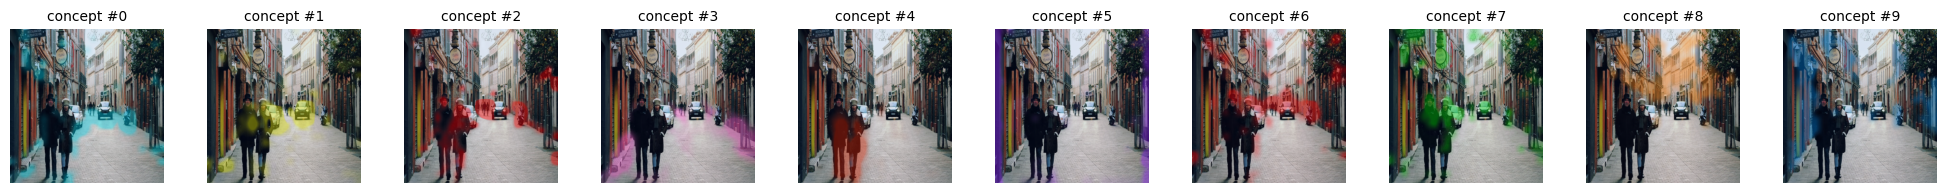

In [53]:
fig = craft.display_images_per_concept(input_tensor, order=None, filter_percentile=80, clip_percentile=5)

Total batches: 1, Batch size: 1, Dataset size: 1
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 25, 25, 10)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Total batches: 1, Batch size: 1, Dataset size: 1


/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\
2025-09-05 17:13:22.994113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


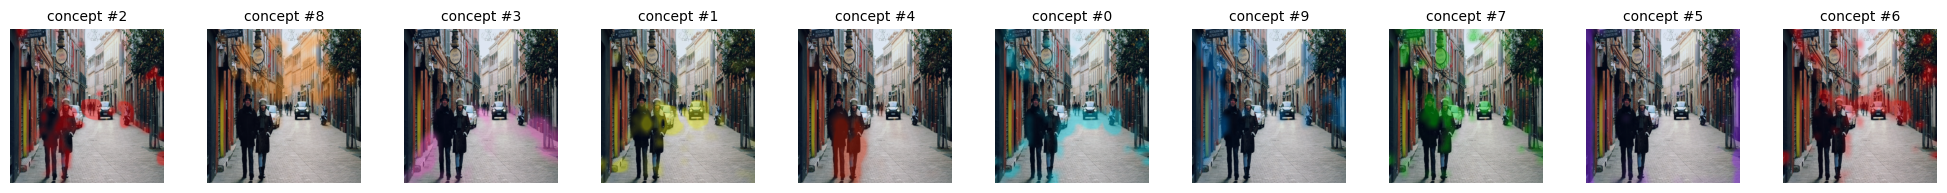

In [54]:
operator = xplique.Tasks.OBJECT_DETECTION
class_id = classes_names.index("person")
importances_gi = craft.estimate_importance_gradient_input_xplique(input_tensor, operator, class_id, accuracy=0.6, batch_size=1)

order = importances_gi.argsort()[::-1]
fig = craft.display_images_per_concept(input_tensor, order=order, filter_percentile=80, clip_percentile=5)